In [2]:
import json
import neptune
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score




In [ ]:
run = neptune.init_run() 

### Load data

In [3]:
dataset = pd.read_parquet("train_pairs_w_target.parquet")
etl = pd.read_parquet("train_data.parquet")

In [4]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [5]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [6]:
etl.head(2)

,variantid,characteristic_attributes_mapping,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64
0,51195767,"{""85"":[""Партнер-Электро""],""8229"":[""Удлинитель ...","Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485..."
1,51196903,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Колодка TDM Electric пятиместная без заземлени...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],"[[0.42044494, -0.33794826, -0.037247024, 0.165...","[[0.16211876, -0.4455993, 0.6131705, 0.5954206...","[-0.48503304, 0.6264443, 0.6406273, -0.4696772..."


In [7]:
print(etl.shape, dataset.shape)

(457063, 8) (306540, 3)


Get raw data for each variantid.

In [8]:
features0 = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [9]:
features0.head(2)

,target,variantid1,variantid2,characteristic_attributes_mapping1,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping2,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642
0,0.0,51197862,51198054,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,..."
1,0.0,51197862,51199884,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392..."


Features functions.

In [10]:
features = features0[:3000]

In [11]:
features["cat31"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat31"].value_counts().to_dict()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\645466129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat31"] = features["categories1"].apply(lambda x: json.loads(x)["3"])


In [12]:
features["cat31_grouped"] = features["cat31"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\3309214132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat31_grouped"] = features["cat31"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")


In [13]:
features["cat32"] = features["categories2"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat32"].value_counts().to_dict()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\3293189207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat32"] = features["categories2"].apply(lambda x: json.loads(x)["3"])


In [14]:
features["cat32_grouped"] = features["cat32"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1050994683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat32_grouped"] = features["cat32"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def create_bag_of_words(sentences):
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(sentences)
    len_sentences = []
    for sentence in sentences:
        len_sentences.append(len(sentence.split()))

    return bag_of_words.toarray(), len_sentences

In [16]:
bag_of_words, len_sentences = create_bag_of_words(np.hstack((features['name1'].values, features['name2'].values)))

In [17]:
print(bag_of_words.shape)

(6000, 3606)


In [18]:
bag_of_words_1, bag_of_words_2 = bag_of_words[:len(bag_of_words) // 2], bag_of_words[len(bag_of_words) // 2:]
len_sentences_1, len_sentences_2 = len_sentences[:len(len_sentences) // 2], len_sentences[len(len_sentences) // 2:]

In [19]:
features["name1_bag"] = bag_of_words_1.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\2543565312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["name1_bag"] = bag_of_words_1.tolist()


In [20]:
features["name2_bag"] = bag_of_words_2.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\3030150248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["name2_bag"] = bag_of_words_2.tolist()


In [21]:
features["name1_len"] = len_sentences_1

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1071916822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["name1_len"] = len_sentences_1


In [22]:
features["name2_len"] = len_sentences_2

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1623139890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["name2_len"] = len_sentences_2


In [23]:
bag_of_words, len_sentences = create_bag_of_words(np.hstack((features['cat31'].values, features['cat32'].values)))

In [24]:
print(bag_of_words.shape)

(6000, 113)


In [25]:
bag_of_words_1, bag_of_words_2 = bag_of_words[:len(bag_of_words) // 2], bag_of_words[len(bag_of_words) // 2:]
len_sentences_1, len_sentences_2 = len_sentences[:len(len_sentences) // 2], len_sentences[len(len_sentences) // 2:]

In [26]:
features["cat31_bag"] = bag_of_words_1.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1746811327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat31_bag"] = bag_of_words_1.tolist()


In [27]:
features["cat32_bag"] = bag_of_words_2.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\313503571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat32_bag"] = bag_of_words_2.tolist()


In [28]:
features["cat31_len"] = len_sentences_1

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\4000331720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat31_len"] = len_sentences_1


In [29]:
features["cat32_len"] = len_sentences_2

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1013834665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["cat32_len"] = len_sentences_2


In [30]:
features.head(2)

,target,variantid1,variantid2,characteristic_attributes_mapping1,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,...,cat32,cat32_grouped,name1_bag,name2_bag,name1_len,name2_len,cat31_bag,cat32_bag,cat31_len,cat32_len
0,0.0,51197862,51198054,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...",...,"Сетевые фильтры, разветвители и удлинители",rest,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5
1,0.0,51197862,51199884,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...",...,"Сетевые фильтры, разветвители и удлинители",rest,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5


In [31]:
gg = features['color_parsed1'].values
color_parsed1 = []
for g in range(len(gg)):
    try:
        color_parsed1.append(gg[g][0])
    except:
        color_parsed1.append('None')
gg1 = features['color_parsed2'].values
for g in range(len(gg1)):
    try:
        color_parsed1.append(gg1[g][0])
    except:
        color_parsed1.append('None')

In [32]:
bag_of_words, len_sentences = create_bag_of_words(color_parsed1)

In [33]:
print(bag_of_words.shape)

(6000, 53)


In [34]:
bag_of_words_1, bag_of_words_2 = bag_of_words[:len(bag_of_words) // 2], bag_of_words[len(bag_of_words) // 2:]
len_sentences_1, len_sentences_2 = len_sentences[:len(len_sentences) // 2], len_sentences[len(len_sentences) // 2:]

In [35]:
features["color1_bag"] = bag_of_words_1.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\1199472630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["color1_bag"] = bag_of_words_1.tolist()


In [36]:
features["color2_bag"] = bag_of_words_2.tolist()

C:\Users\druzh\AppData\Local\Temp\ipykernel_9204\4123931162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["color2_bag"] = bag_of_words_2.tolist()


In [37]:
features.head(2)

,target,variantid1,variantid2,characteristic_attributes_mapping1,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,...,name1_bag,name2_bag,name1_len,name2_len,cat31_bag,cat32_bag,cat31_len,cat32_len,color1_bag,color2_bag
0,0.0,51197862,51198054,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.0,51197862,51199884,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
feats = ["name1_bag", "name1_len", "name2_bag", "name2_len", "cat31_bag", "cat32_bag", "cat31_len", "cat32_len", "color1_bag", 'color2_bag']

In [73]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat31_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target"]])

X_train, X_val = train_test_split(
    X_train[feats + ["target"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target"]])

cats = X_test["cat31_grouped"]
y_test_w_var = X_test[["target", "variantid1", "variantid2"]]
y_test = X_test[["target"]]

X_test = X_test.drop(["target", "variantid1", "variantid2", "cat31_grouped"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)

        


In [81]:
cats

36                   rest
196                  rest
1745                 rest
39                   rest
2334    Игровая приставка
              ...        
885                  rest
562                  rest
2959    Игровая приставка
2037    Игровая приставка
2303    Игровая приставка
Name: cat31_grouped, Length: 300, dtype: object

In [57]:
X_train_final = []

for i in range(len(X_train)):
    row = []
    row.extend(list(X_train[feats[0]].iloc[i]))
    row.extend(list(X_train[feats[2]].iloc[i]))
    row.extend(list(X_train[feats[4]].iloc[i]))
    row.extend(list(X_train[feats[5]].iloc[i]))
    row.extend(list(X_train[feats[8]].iloc[i]))
    row.extend(list(X_train[feats[9]].iloc[i]))
    row.extend([X_train[feats[b]].iloc[i] for b in [1,3,6,7]])
    X_train_final.append(row)

In [58]:
print(len(X_train_final))

2430


In [59]:
print(y_train)

428     0.0
1313    1.0
1969    1.0
1584    1.0
2442    1.0
       ... 
2719    1.0
1877    1.0
1776    0.0
1381    0.0
1186    1.0
Name: target, Length: 2430, dtype: float64


In [60]:
X_test_final = []

for i in range(len(X_test)):
    row = []
    row.extend(list(X_test[feats[0]].iloc[i]))
    row.extend(list(X_test[feats[2]].iloc[i]))
    row.extend(list(X_test[feats[4]].iloc[i]))
    row.extend(list(X_test[feats[5]].iloc[i]))
    row.extend(list(X_test[feats[8]].iloc[i]))
    row.extend(list(X_test[feats[9]].iloc[i]))
    row.extend([X_test[feats[b]].iloc[i] for b in [1,3,6,7]])
    X_test_final.append(row)

In [61]:
print(len(X_test_final))

300


In [62]:
print(y_test)

      target
36       0.0
196      0.0
1745     0.0
39       0.0
2334     1.0
...      ...
885      1.0
562      0.0
2959     1.0
2037     1.0
2303     1.0

[300 rows x 1 columns]


In [63]:


from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_final, y_train)




LogisticRegression(max_iter=1000)

In [64]:
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
prediction = model.predict(X_test_final)

mse = mean_squared_error(y_test, prediction)
print("Mean Squared Error:", mse)

f1 = f1_score(y_test, prediction)
print("f1:", f1)

accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Mean Squared Error: 0.13333333333333333
f1: 0.898477157360406
Accuracy: 0.8666666666666667
Precision: 0.8592233009708737
Recall: 0.9414893617021277


In [69]:
print(len(prediction))

300


In [120]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    y_true: pd.Series,
    y_pred: pd.Series,
    categories: pd.Series,
    prec_level: float = 0.75
) -> float:
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)
    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        print(cat_idx)
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]
        y_true_cat = y_true_cat.T 
        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [121]:
X_test["scores"] = prediction
y_pred = X_test["scores"]
y_test = y_test.reset_index(drop = True)
y_pred = y_pred.reset_index(drop = True)
cats = cats.reset_index(drop = True)
y_test = y_test.T

In [122]:
pr_auc_macro_metr = pr_auc_macro(
    y_true=y_test, 
    y_pred=y_pred,
    categories = cats,
    prec_level=0.75
)

pr_auc_macro_metr

[  0   1   2   3   5   6   7  10  11  12  14  15  16  17  21  22  23  25
  29  33  34  35  36  37  38  39  41  42  43  45  53  54  55  57  60  63
  67  69  70  72  74  75  76  77  78  80  81  82  84  85  87  89  95  98
  99 100 102 106 107 108 110 111 112 117 119 120 121 123 124 125 130 132
 134 139 140 141 143 144 145 146 150 152 154 155 157 159 161 164 166 167
 169 171 172 174 176 177 179 181 182 184 185 187 188 190 194 195 196 197
 198 199 200 201 204 205 207 208 210 213 215 216 218 219 220 221 222 226
 228 230 232 234 235 239 240 242 243 245 246 248 249 250 256 260 265 267
 269 270 271 274 275 276 280 281 282 283 284 285 288 290 291 292 293 295
 296]
[  4   8   9  13  18  19  20  24  26  27  28  30  31  32  40  44  46  47
  48  49  50  51  52  56  58  59  61  62  64  65  66  68  71  73  79  83
  86  88  90  91  92  93  94  96  97 101 103 104 105 109 113 114 115 116
 118 122 126 127 128 129 131 133 135 136 137 138 142 147 148 149 151 153
 156 158 160 162 163 165 168 170 173 175 178 

0.9781021897810219

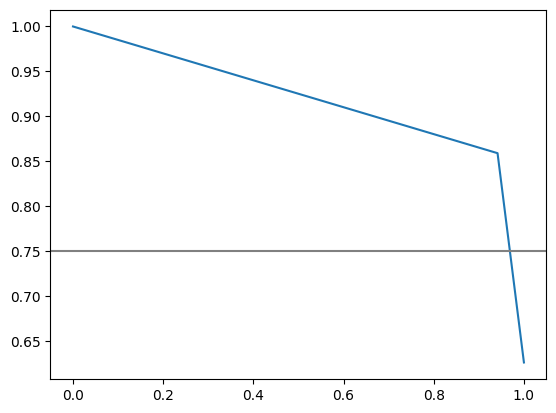

In [128]:
precision, recall, thrs = precision_recall_curve(y_test.T, y_pred)
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1)

ax1.plot( recall , precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');